In [15]:
# %pip install numpy pandas scikit-learn xgboost matplotlib seaborn
# %pip install joblib

# Import necessary libraries
import pandas as pd
import numpy as np
import joblib
import os

# For data preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import PredefinedSplit

# For regression models
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# For evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('spotify_tracks_dataset_processed.csv')

# drop the rows for which popularity value is <= 70
df = df[ df['popularity'] > 70 ]

df.head()

,Unnamed: 0,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,82,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [30]:
df.describe()

,Unnamed: 0,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000
mean,32844.703639,76.301622,218214.140289,0.196405,0.623305,0.664479,5.401578,-6.632677,0.610259,0.081474,0.230638,0.029575,0.171410,0.507065,120.732375,3.940377
std,18739.981181,4.832750,56414.157015,0.397366,0.151512,0.190757,3.584699,3.050786,0.487798,0.078578,0.259779,0.123532,0.125181,0.230437,28.054631,0.303410
min,0.000000,71.000000,53247.000000,0.000000,0.000000,0.001890,0.000000,-30.704000,0.000000,0.000000,0.000005,0.000000,0.021900,0.000000,0.000000,0.000000
25%,15037.000000,72.000000,183440.000000,0.000000,0.523000,0.536000,2.000000,-8.126000,0.000000,0.035000,0.020500,0.000000,0.092500,0.329000,99.969000,4.000000
50%,33900.000000,75.000000,210960.000000,0.000000,0.633000,0.687000,6.000000,-5.968000,1.000000,0.049300,0.120000,0.000003,0.121000,0.497000,119.942000,4.000000
75%,46311.000000,79.000000,244013.000000,0.000000,0.737000,0.817000,9.000000,-4.542000,1.000000,0.088200,0.369000,0.000510,0.214000,0.687000,137.958000,4.000000
max,70891.000000,100.000000,595105.000000,1.000000,0.980000,0.996000,11.000000,-0.140000,1.000000,0.537000,0.983000,0.899000,0.799000,0.979000,207.970000,5.000000


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2281 entries, 0 to 70891
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2281 non-null   int64  
 1   popularity        2281 non-null   int64  
 2   duration_ms       2281 non-null   int64  
 3   explicit          2281 non-null   int64  
 4   danceability      2281 non-null   float64
 5   energy            2281 non-null   float64
 6   key               2281 non-null   int64  
 7   loudness          2281 non-null   float64
 8   mode              2281 non-null   int64  
 9   speechiness       2281 non-null   float64
 10  acousticness      2281 non-null   float64
 11  instrumentalness  2281 non-null   float64
 12  liveness          2281 non-null   float64
 13  valence           2281 non-null   float64
 14  tempo             2281 non-null   float64
 15  time_signature    2281 non-null   int64  
 16  track_genre       2281 non-null   object 
dtyp

In [ ]:
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Separate features and target
X = df.drop('popularity', axis=1)
y = df['popularity']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Target encoding for 'track_genre' only
encoder = TargetEncoder(cols=['track_genre'])
X_train['track_genre'] = encoder.fit_transform(X_train['track_genre'], y_train)
X_test['track_genre'] = encoder.transform(X_test['track_genre'])

# Drop 'Unnamed: 0' column
X_train.drop(['Unnamed: 0'], axis=1, inplace=True)
X_test.drop(['Unnamed: 0'], axis=1, inplace=True)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95, random_state=42)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Optional: Save the PCA model for future use

joblib.dump(pca, 'models/pca_model.joblib')
print("Saved PCA model to models/pca_model.joblib")

# Now, use X_train_pca and X_test_pca for model training and evaluation
# Example:
# best_model.fit(X_train_pca, y_train)
# y_pred = best_model.predict(X_test_pca)

Saved PCA model to models/pca_model.joblib


In [21]:


# Dictionary of regression models and their respective hyperparameter grids
models = {
    'Lasso': {
        'model': Lasso(random_state=42),
        'params': {
            'alpha': np.logspace(-4, 0, 100),
            'max_iter': [1000, 5000, 10000],
            'tol': [1e-4, 1e-3, 1e-2],
            'selection': ['cyclic', 'random']
        }
    },
    'Ridge': {
        'model': Ridge(random_state=42),
        'params': {
            'alpha': np.logspace(-4, 0, 100),
            'max_iter': [1000, 5000, 10000],
            'tol': [1e-4, 1e-3, 1e-2]
        }
    },
    'ElasticNet': {
        'model': ElasticNet(random_state=42),
        'params': {
            'alpha': np.logspace(-4, 0, 100),
            'l1_ratio': np.linspace(0, 1, 20),
            'max_iter': [1000, 5000, 10000],
            'tol': [1e-4, 1e-3, 1e-2]
        }
    },
    # 'SVR': {
    #     'model': SVR(),
    #     'params': {
    #         'C': [0.1, 1, 10, 100],
    #         'kernel': ['linear', 'rbf', 'poly'],
    #         'gamma': ['scale', 'auto']
    #     }
    # },
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300, 400, 500],
            'max_depth': [10, 15, 20, 25, 30, None],
            'min_samples_split': [2, 5, 10, 15, 20],
            'min_samples_leaf': [1, 2, 4, 6, 8],
            'max_features': ['auto', 'sqrt', 'log2']
        }
    },
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 4, 5, 6, 7],
            'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2']
        }
    },
    'AdaBoostRegressor': {
        'model': AdaBoostRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 150, 200, 250],
            'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0],
            'loss': ['linear', 'square', 'exponential']
        }
    },
    'KNeighborsRegressor': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']
        }
    },
    'XGBRegressor': {
        'model': XGBRegressor(random_state=42, objective='reg:squarederror'),
        'params': {
            'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 4, 5, 6, 7],
            'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
            'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
            'gamma': [0, 0.1, 0.2, 0.3, 0.4],
            'reg_alpha': [0, 0.1, 0.5, 1.0],
            'reg_lambda': [1, 1.5, 2.0, 2.5]
        }
    }
}

In [22]:
# -----------------------------
# 3. Define a Custom Accuracy Metric
# -----------------------------

def regression_accuracy(y_true, y_pred, tolerance=10):
    """
    Calculates the percentage of predictions within a specified tolerance.
    
    Parameters:
    - y_true: Actual target values
    - y_pred: Predicted target values
    - tolerance: The maximum allowable difference between actual and predicted values
    
    Returns:
    - accuracy_percentage: Percentage of predictions within the tolerance
    """
    correct_predictions = np.abs(y_true - y_pred) <= tolerance
    accuracy_percentage = np.mean(correct_predictions) * 100
    return accuracy_percentage

# Define p_index_analysis function (if it is a custom function)
def p_index_analysis(y_true, y_pred):
    # Avoid division by zero
    non_zero = y_true != 0
    p_index = np.mean(np.abs(y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero]) * 100
    return p_index

In [23]:
# from sklearn.metrics import mean_absolute_percentage_error

# # -----------------------------
# # 4. Hyperparameter Tuning and Model Evaluation
# # -----------------------------

# # Initialize a list to store summary results
# import os
# summary_results = []

# # Create directories to store cross-validation results, models, and plots if they don't exist
# os.makedirs('cv_results', exist_ok=True)
# os.makedirs('models', exist_ok=True)
# os.makedirs('plots', exist_ok=True)

# # Iterate over each model for hyperparameter tuning
# for model_name, mp in models.items():
#     print(f"\n\nProcessing {model_name}...\n")
#     model = mp['model']
#     params = mp['params']
    
#     # # Choose the appropriate search method
#     # # Use RandomizedSearchCV for models with large hyperparameter spaces
#     # if model_name in ['SVR', 'RandomForestRegressor', 'GradientBoostingRegressor', 'AdaBoostRegressor', 'KNeighborsRegressor', 'XGBRegressor']:
#     #     search = RandomizedSearchCV(
#     #         estimator=model,
#     #         param_distributions=params,
#     #         n_iter=200,  # Number of parameter settings sampled; adjust based on computational resources
#     #         scoring='neg_mean_squared_error',
#     #         cv=5,
#     #         verbose=1,
#     #         random_state=42,
#     #         n_jobs=-1
#     #     )
#     # else:
#     #     search = GridSearchCV(
#     #         estimator=model,
#     #         param_grid=params,
#     #         scoring='neg_mean_squared_error',
#     #         cv=5,
#     #         verbose=1,
#     #         n_jobs=-1
#     #     )

#     search = GridSearchCV(
#         estimator=model,
#         param_grid=params,
#         scoring="neg_mean_squared_error",
#         cv=5,
#         verbose=1,
#         n_jobs=-1,
#     )
    
#     # Fit the model with hyperparameter tuning
#     search.fit(X_train_scaled, y_train)
    
#     # Save cross-validation results to CSV
#     cv_results = pd.DataFrame(search.cv_results_)
#     cv_results.to_csv(f'cv_results/{model_name}_cv_results.csv', index=False)
#     print(f"Saved cross-validation results for {model_name} to cv_results/{model_name}_cv_results.csv")
    
#     # Best estimator after tuning
#     best_model = search.best_estimator_
#     print(f"Best Parameters for {model_name}: {search.best_params_}")
    
#     # Predict on training data
#     y_train_pred = best_model.predict(X_train_scaled)
    
#     # Predict on testing data
#     y_test_pred = best_model.predict(X_test_scaled)
    
#     # Calculate evaluation metrics
#     train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
#     train_mae = mean_absolute_error(y_train, y_train_pred)
#     train_mape = mean_absolute_percentage_error(y_train, y_train_pred) * 100
#     train_r2 = r2_score(y_train, y_train_pred)
#     train_accuracy = regression_accuracy(y_train, y_train_pred, tolerance=5)
#     train_p_index = p_index_analysis(y_train, y_train_pred)
    
#     test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
#     test_mae = mean_absolute_error(y_test, y_test_pred)
#     test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100
#     test_r2 = r2_score(y_test, y_test_pred)
#     test_accuracy = regression_accuracy(y_test, y_test_pred, tolerance=5)
#     test_p_index = p_index_analysis(y_test, y_test_pred)
    
#     # Append the results to the summary list
#     summary_results.append({
#         'Model': model_name,
#         'Best Parameters': search.best_params_,
#         'Train RMSE': train_rmse,
#         'Train MAE': train_mae,
#         'Train MAPE (%)': train_mape,
#         'Train R2': train_r2,
#         'Train Accuracy (%)': train_accuracy,
#         'Train P Index': train_p_index,
#         'Test RMSE': test_rmse,
#         'Test MAE': test_mae,
#         'Test MAPE (%)': test_mape,
#         'Test R2': test_r2,
#         'Test Accuracy (%)': test_accuracy,
#         'Test P Index': test_p_index
#         # MAPE, p index analysis, etc
#     })
    
#     print(f"Evaluation Metrics for {model_name}:")
#     print(f"Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}, Train MAPE: {train_mape:.2f}%, Train R2: {train_r2:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train P Index: {train_p_index:.2f}")
#     print(f"Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}, Test MAPE: {test_mape:.2f}%, Test R2: {test_r2:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test P Index: {test_p_index:.2f}")

In [ ]:
# -----------------------------
# 4. Hyperparameter Tuning and Model Evaluation
# -----------------------------

# Initialize a list to store summary results
summary_results = []

# Create directories to store cross-validation results, models, and plots if they don't exist
os.makedirs('cv_results', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('plots', exist_ok=True)

# Iterate over each model for hyperparameter tuning
for model_name, mp in models.items():
    print(f"\n\nProcessing {model_name}...\n")
    model = mp['model']
    params = mp['params']
    
    # # Initialize GridSearchCV for all models
    # search = GridSearchCV(
    #     estimator=model,
    #     param_grid=params,
    #     scoring="neg_mean_squared_error",
    #     cv=5,
    #     verbose=1,
    #     n_jobs=-1,
    # )
    
    # # Fit the model with hyperparameter tuning using PCA-transformed data
    # search.fit(X_train_pca, y_train)

    test_fold = np.full(len(y_train), -1)  # All -1 indicates no validation
    custom_cv = PredefinedSplit(test_fold)

    n_iter = 1500  # Adjust based on available computational power and time
    
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=n_iter,
        scoring="neg_mean_squared_error",
        cv=custom_cv,
        verbose=1,
        random_state=42,
        n_jobs=-1,
    )

    # Create a predefined split with all training data (no validation)
    test_fold = np.full(X_train_pca.shape[0], -1)  # All -1 means all data is treated as training
    custom_cv = PredefinedSplit(test_fold)

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=n_iter,
        scoring="neg_mean_squared_error",
        cv=[(slice(None), slice(None))],  # Use a predefined split to avoid cross-validation
        verbose=1,
        random_state=42,
        n_jobs=-1,
    )
    
    # Fit the model with hyperparameter tuning using PCA-transformed data
    try:
        search.fit(X_train_pca, y_train)
    except Exception as e:
        print(f"Error during fitting {model_name}: {e}")
        continue  # Skip to the next model if there's an error
    
    # Save cross-validation results to CSV
    cv_results = pd.DataFrame(search.cv_results_)
    cv_results.to_csv(f'cv_results/{model_name}_cv_results.csv', index=False)
    print(f"Saved cross-validation results for {model_name} to cv_results/{model_name}_cv_results.csv")
    
    # Best estimator after tuning
    best_model = search.best_estimator_
    print(f"Best Parameters for {model_name}: {search.best_params_}")
    
    # Save the best model
    joblib.dump(best_model, f"models/best_{model_name}.joblib")
    print(f"Saved the best {model_name} model to models/best_{model_name}.joblib")
    
    # Predict on training data using PCA-transformed data
    y_train_pred = best_model.predict(X_train_pca)
    
    # Predict on testing data using PCA-transformed data
    y_test_pred = best_model.predict(X_test_pca)
    
    # Calculate evaluation metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred) * 100
    train_r2 = r2_score(y_train, y_train_pred)
    train_accuracy = regression_accuracy(y_train, y_train_pred, tolerance=5)
    train_p_index = p_index_analysis(y_train, y_train_pred)
    
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100
    test_r2 = r2_score(y_test, y_test_pred)
    test_accuracy = regression_accuracy(y_test, y_test_pred, tolerance=5)
    test_p_index = p_index_analysis(y_test, y_test_pred)
    
    # Append the results to the summary list
    summary_results.append({
        'Model': model_name,
        'Best Parameters': search.best_params_,
        'Train RMSE': train_rmse,
        'Train MAE': train_mae,
        'Train MAPE (%)': train_mape,
        'Train R2': train_r2,
        'Train Accuracy (%)': train_accuracy,
        'Train P Index': train_p_index,
        'Test RMSE': test_rmse,
        'Test MAE': test_mae,
        'Test MAPE (%)': test_mape,
        'Test R2': test_r2,
        'Test Accuracy (%)': test_accuracy,
        'Test P Index': test_p_index
    })
    
    print(f"Evaluation Metrics for {model_name}:")
    print(f"Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}, Train MAPE: {train_mape:.2f}%, Train R2: {train_r2:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train P Index: {train_p_index:.2f}")
    print(f"Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}, Test MAPE: {test_mape:.2f}%, Test R2: {test_r2:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test P Index: {test_p_index:.2f}")




Processing Lasso...

Fitting 1 folds for each of 500 candidates, totalling 500 fits


Saved cross-validation results for Lasso to cv_results/Lasso_cv_results.csv
Best Parameters for Lasso: {'tol': 0.0001, 'selection': 'random', 'max_iter': 10000, 'alpha': 0.0001}
Saved the best Lasso model to models/best_Lasso.joblib
Evaluation Metrics for Lasso:
Train RMSE: 4.3028, Train MAE: 3.3071, Train MAPE: 4.26%, Train R2: 0.2142, Train Accuracy: 80.04%, Train P Index: 4.26
Test RMSE: 4.1793, Test MAE: 3.3941, Test MAPE: 4.39%, Test R2: 0.2231, Test Accuracy: 78.77%, Test P Index: 4.39


Processing Ridge...

Fitting 1 folds for each of 500 candidates, totalling 500 fits
Saved cross-validation results for Ridge to cv_results/Ridge_cv_results.csv
Best Parameters for Ridge: {'tol': 0.01, 'max_iter': 5000, 'alpha': 0.0001}
Saved the best Ridge model to models/best_Ridge.joblib
Evaluation Metrics for Ridge:
Train RMSE: 4.3028, Train MAE: 3.3071, Train MAPE: 4.26%, Train R2: 0.2142, Train Accuracy: 80.04%, Train P Index: 4.26
Test RMSE: 4.1793, Test MAE: 3.3940, Test MAPE: 4.39%, Test 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.689e+04, tolerance: 4.298e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.689e+04, tolerance: 4.298e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

Saved cross-validation results for ElasticNet to cv_results/ElasticNet_cv_results.csv
Best Parameters for ElasticNet: {'tol': 0.01, 'max_iter': 1000, 'l1_ratio': 0.10526315789473684, 'alpha': 0.00010974987654930556}
Saved the best ElasticNet model to models/best_ElasticNet.joblib
Evaluation Metrics for ElasticNet:
Train RMSE: 4.3028, Train MAE: 3.3071, Train MAPE: 4.26%, Train R2: 0.2142, Train Accuracy: 80.04%, Train P Index: 4.26
Test RMSE: 4.1793, Test MAE: 3.3941, Test MAPE: 4.39%, Test R2: 0.2231, Test Accuracy: 78.77%, Test P Index: 4.39


Processing RandomForestRegressor...

Fitting 1 folds for each of 500 candidates, totalling 500 fits
Saved cross-validation results for RandomForestRegressor to cv_results/RandomForestRegressor_cv_results.csv
Best Parameters for RandomForestRegressor: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Saved the best RandomForestRegressor model to models/best_RandomForestRegressor.jobli

In [25]:
# -----------------------------
# 5. Save Summary of All Models
# -----------------------------

# Convert summary results to a DataFrame
results_df = pd.DataFrame(summary_results)

# Save the summary results to a CSV file
results_df.to_csv('70to100_model_results_summary.csv', index=False)
print("\nAll model results have been saved to 70to100_model_results_summary.csv")

# Display the summary results
print("\nFinal Summary of All Models:")
print(results_df)


All model results have been saved to 70to100_model_results_summary.csv

Final Summary of All Models:
                       Model  \
0                      Lasso   
1                      Ridge   
2                 ElasticNet   
3      RandomForestRegressor   
4  GradientBoostingRegressor   
5          AdaBoostRegressor   
6        KNeighborsRegressor   
7               XGBRegressor   

                                     Best Parameters  Train RMSE  Train MAE  \
0  {'tol': 0.0001, 'selection': 'random', 'max_it...    4.302797   3.307060   
1   {'tol': 0.01, 'max_iter': 5000, 'alpha': 0.0001}    4.302797   3.307053   
2  {'tol': 0.01, 'max_iter': 1000, 'l1_ratio': 0....    4.302797   3.307063   
3  {'n_estimators': 500, 'min_samples_split': 2, ...    1.657940   1.284671   
4  {'subsample': 1.0, 'n_estimators': 500, 'min_s...    0.126092   0.005740   
5  {'n_estimators': 100, 'loss': 'exponential', '...    4.310813   3.478871   
6  {'weights': 'distance', 'n_neighbors': 3, 'met...    

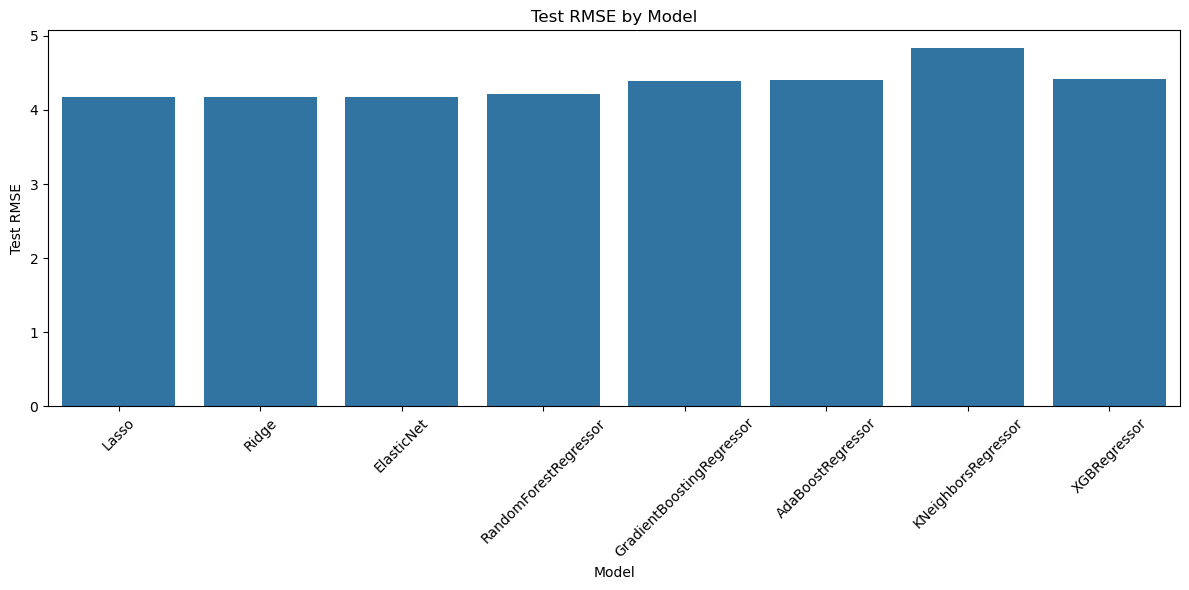

In [26]:
# -----------------------------
# 6. (Optional) Visualization of Results
# -----------------------------

# Example: Plot Test RMSE by Model
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Test RMSE', data=results_df)
plt.xticks(rotation=45)
plt.title('Test RMSE by Model')
plt.tight_layout()
plt.savefig('plots/Test_RMSE_by_Model.png')
plt.show()

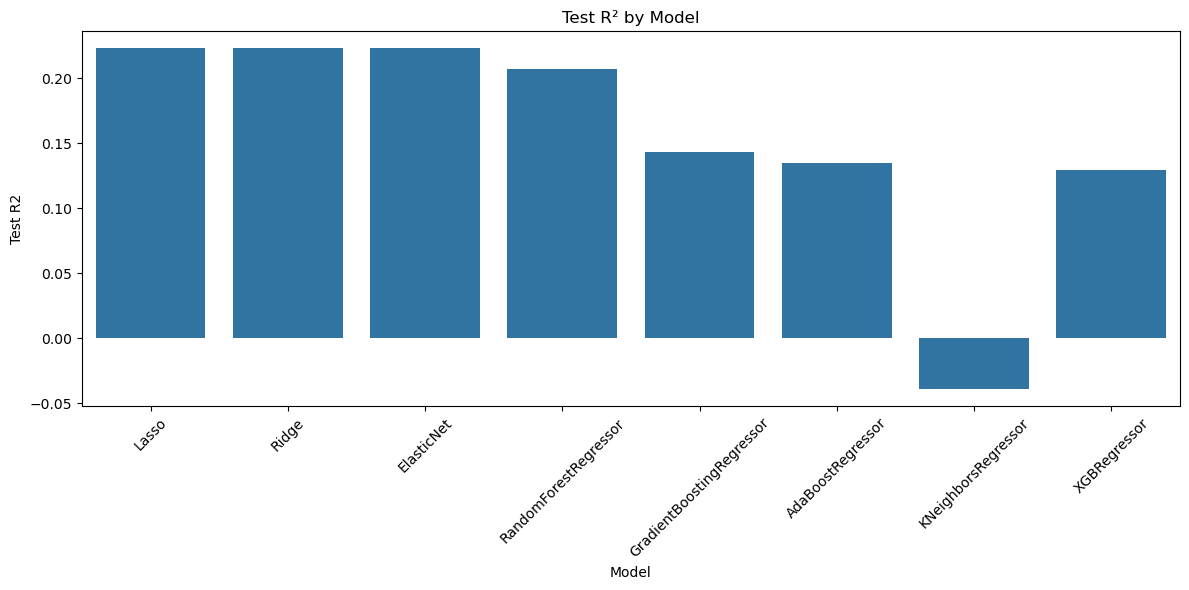

In [27]:
# Example: Plot Test R² by Model
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Test R2', data=results_df)
plt.xticks(rotation=45)
plt.title('Test R² by Model')
plt.tight_layout()
plt.savefig('plots/Test_R2_by_Model.png')
plt.show()

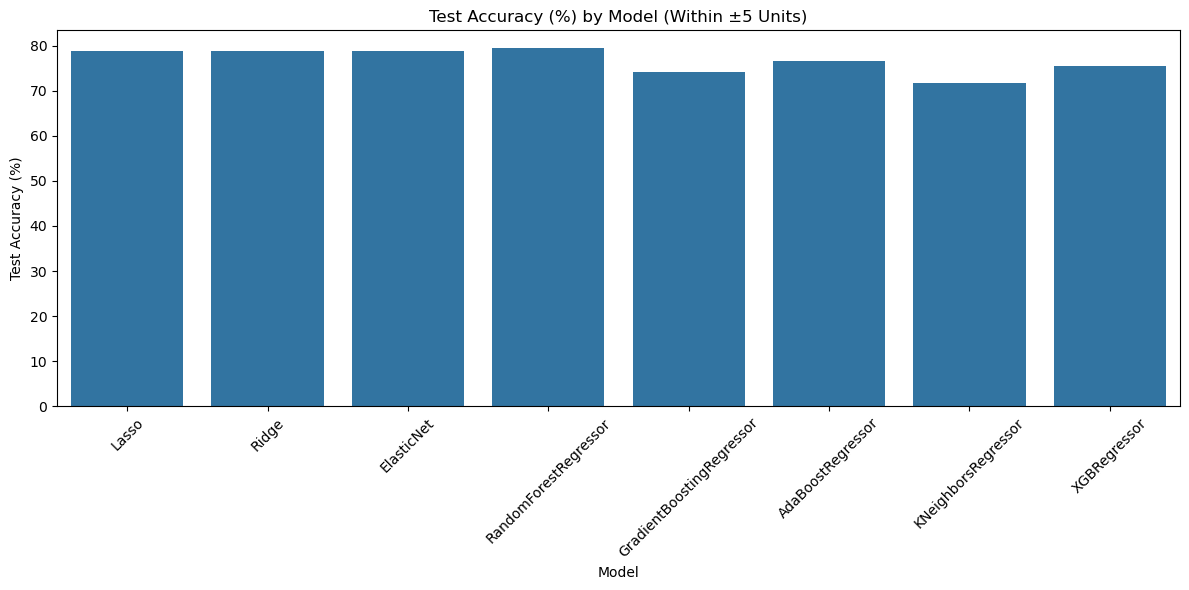

In [28]:
# Example: Plot Test Accuracy by Model
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Test Accuracy (%)', data=results_df)
plt.xticks(rotation=45)
plt.title('Test Accuracy (%) by Model (Within ±5 Units)')
plt.tight_layout()
plt.savefig('plots/Test_Accuracy_by_Model.png')
plt.show()